# Getting Structured Data for model Training

<li> As discussed in abstract, the general structure of neural network that is going to be used will be as follows: </li>

<img src="https://drive.google.com/uc?id=12dKetInXIZ7ZlvIbgIi-Csg8jBRROYGF" width="400" height="800">

<li> We can see there are two inputs for model. First one is tokenized cleaned tweet text and other is feature matrix. </li>
<li> All the inputs in this network are for complete day but the data that we have is for each tweet along with date. So what we need to do is combine the tweet text for complete day and get a long string representing all tweets from that day. </li>
<li> Now to create second input that is feature matrix, we need to stack each feature vector vertically so that the dimension for each day will be like (number of tweets on that day, feature vec dimension). </li>
<li> But the problem here is number of tweets on a particular day are not fixed. Hence a proper length of text data and feature matrix has to be selected. </li>

#### Let us analyze the number of tweets on each day to get an idea about the maximum and minimum tweets on a particular day.

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import pickle
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv("preprocessed_data.csv")

# Cells where hashtag was absent had 'NaN' values when they were saved in csv format
# hence filling these with 0 which will be processed later in this notebook
data['hashtags'] = data['hashtags'].fillna(0)

# Some tweets had null text after cleaning. Hence we need to remove those. The number of empty tweet text is very low
data = data.dropna()
data.head()

,post_date,ticker_symbol,tweet_id,comment_num,retweet_num,like_num,URL_flag,hastags_flag,mention_flag,hashtags,tweet_cleaned,neg,neu,pos,compound,change_label,class_sign,close_value_change
0,2015-01-01,AAPL,550802957370159104,0.003170,0.002006,0.004004,1,0,1,0,aapl store line sapporo japan lucky bag pic ht,0.0,0.741,0.259,0.4215,0.0,1,0.0
1,2015-01-01,AAPL,550781053137616896,0.007924,0.035105,0.022022,1,0,0,0,wall street top pick 2015 hint not aapl googl,0.0,0.816,0.184,0.2023,0.0,1,0.0
2,2015-01-01,AAPL,550779709840445441,0.023772,0.221665,0.109109,1,0,0,0,see tech companies like apple twitter facebook...,0.0,0.815,0.185,0.3612,0.0,1,0.0
3,2015-01-01,AAPL,550777620422729728,0.011094,0.011033,0.008008,1,0,0,0,new hed story apple press goes half cocked aapl,0.0,1.000,0.000,0.0000,0.0,1,0.0
4,2015-01-01,AAPL,550774071210696704,0.000000,0.001003,0.005005,1,1,0,APPLE,4 value stocks 2015 aapl alu expe kors pcln qc...,0.0,0.833,0.167,0.3400,0.0,1,0.0


In [3]:
print("Shape of data is : ",data.shape)

Shape of data is :  (318142, 18)


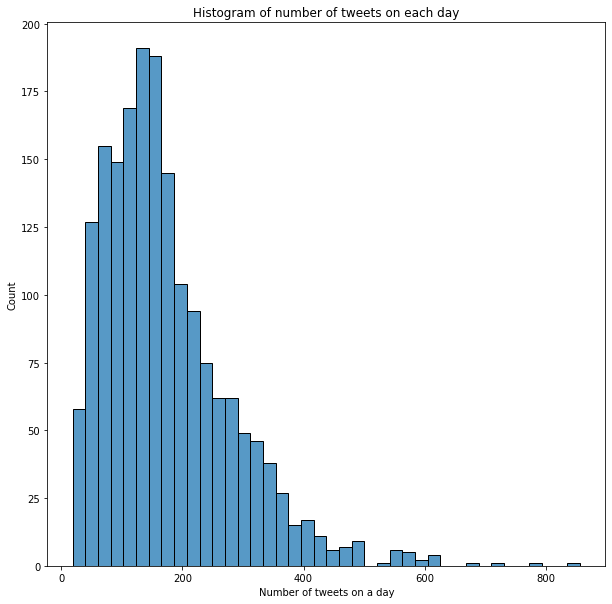

In [4]:
# Getting number of tweets w.r.t. dates 
temp = data.groupby(['post_date']).count()['tweet_id']
counts = list(temp)

plt.figure(figsize=(10,10))
sns.histplot(counts)
plt.title("Histogram of number of tweets on each day")
plt.xlabel("Number of tweets on a day")
plt.ylabel("Count")
plt.show()

<li> We can see most of the days have tweets less than 600 tweets/day. </li>
<li> Let us analyse this more with percentile values. </li>

In [5]:
# let us print percentile values of these lengths from 0 100th percentile

for i in range(0,110,10):
    print("{}th percentile value for Number of tweets on a day is : {}".format(i,np.percentile(counts,i)))

0th percentile value for Number of tweets on a day is : 19.0
10th percentile value for Number of tweets on a day is : 60.0
20th percentile value for Number of tweets on a day is : 85.0
30th percentile value for Number of tweets on a day is : 109.0
40th percentile value for Number of tweets on a day is : 131.0
50th percentile value for Number of tweets on a day is : 151.0
60th percentile value for Number of tweets on a day is : 172.0
70th percentile value for Number of tweets on a day is : 205.5
80th percentile value for Number of tweets on a day is : 253.0
90th percentile value for Number of tweets on a day is : 316.0
100th percentile value for Number of tweets on a day is : 856.0


<li> We can see 100th percentile value is approx 800 tweets per day. Ideally this number should be considered but due to compuation limitation, we will try to train with more than 90th percentile value that is 500-600 tweets/day. </li>

### 1. Combining Tweet Text with respect to Date

<li> Two class labels are being generated here. One is maginute of % changes in stock prices while other one is sign of change. </li>
<li> Both of these class labels will be used for model training. </li>

<li> albert-base is a pretrained model on text data which is trained on Masked language modelling ( predicting missing words to train ). THis can be very useful in getting feature vectors from text. Hence extracting these feature vectors as well after combining the text </li>

In [6]:
# referred albert-base model from below link
# https://huggingface.co/albert-base-v2

from transformers import AlbertTokenizer, TFAlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = TFAlbertModel.from_pretrained("albert-base-v2")

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [7]:
# sorting w.r.t. to date in order to temporaly split data in train and test
data = data.sort_values(by=['post_date'])

# Getting two class labels
# One is % change magnitute and other one is the direction of change
#data['change_label'] = data.close_value_change.apply(lambda x:-x if x<0 else x)
#data['class_sign'] = data.close_value_change.apply(lambda x:-1 if x<0 else 1)

dates = data['post_date'].unique()
companies = data['ticker_symbol'].unique()  

# empty list to store % change magnitude
change_label = {}


# empty list to store change direction sign 
sign_change = {}

# empty list to store combined tweet text
tweets = {}

tweet_vec = {}

for date in tqdm(dates):
    tweet_data = data[data.post_date == date]
    # empty string to store and accumulate tweet text for a day
    all_tweets = ''
    # loop to iterate through all tweets on that day
    for tweet in tweet_data['tweet_cleaned']: 
        all_tweets += tweet
    
    # storing all tweets to tweets dictionary
    tweets[date] = all_tweets
    
    
    # limiting the text word lengths to 220 since albert-base model has maximum token lengths as 512
    # and also due to computational limitations
    all_tweets = ' '.join(all_tweets.split()[:220])
    
    
    # limiting the text word lengths to 220 since albert-base model has maximum token lengths as 512
    # and also due to computational limitations
    #all_tweets = ' '.join(all_tweets.split()[:220])
    
    # getting albert-base model output and storing it to the respective dictionary
    # taking mean of all word vectors obtained from albert base
    #tweet_vec[date] = np.mean(np.array(model(tokenizer(all_tweets, return_tensors='tf')
                                            #)['last_hidden_state']),axis=1)[0]
    
    
    change_label[date] = {}
    
    sign_change[date] = {}
    
    for company in companies:
        
        temp = data[(data.post_date == date) & (data.ticker_symbol == company)]


        try:
            change_label[date][company] = temp['change_label'].unique()[0]
            sign_change[date][company] = temp['class_sign'].unique()[0]
        except:
            change_label[date][company] = 0
            sign_change[date][company] = 0

100%|██████████████████████████████████████████████████████████████████████████████| 1826/1826 [06:17<00:00,  4.83it/s]


<li> Now that we have combined tweet text, let us observe the text lengths so that we get an idea regarding minimum fixed sequence lengths required without losing much data. </li>
<li> We can pad the sequence if length is shorter and trim the seqeunce if those are lengthier. </li>
<li> This is done in order to enable batch training by having equal input length. </li>

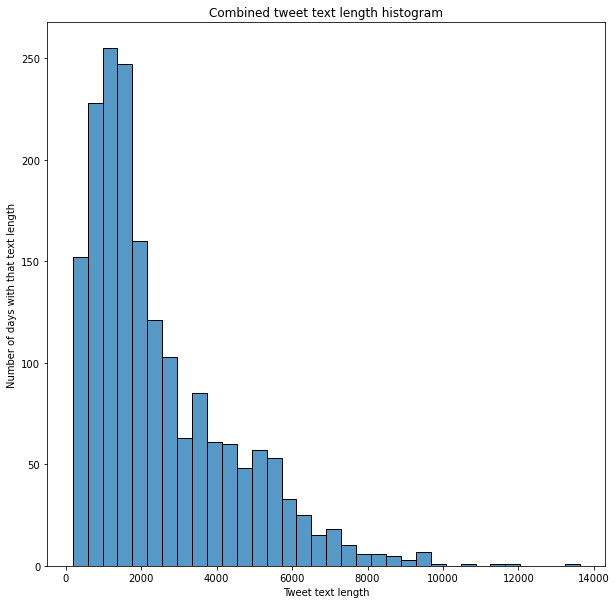

In [8]:
# getting lengths of all combined tweet text data
len_tweets = [len(i.split()) for i in tweets.values()]

plt.figure(figsize=(10,10))
sns.histplot(len_tweets)
plt.title("Combined tweet text length histogram")
plt.xlabel("Tweet text length")
plt.ylabel("Number of days with that text length")
plt.show()

<li> We can observe that number of words in tweet text vary from 0 to approx 20000 </li>
<li> This length of tweet texts will not feasible for model training. Hence a fix length of sequence should be selected. Let us observe percentile values for these tweet text data. </li>

In [9]:
# let us print percentile values of these lengths from 0 100th percentile

for i in range(0,110,10):
    print("{}th percentile value for tweet length is : {}".format(i,np.percentile(len_tweets,i)))

0th percentile value for tweet length is : 185.0
10th percentile value for tweet length is : 627.0
20th percentile value for tweet length is : 948.0
30th percentile value for tweet length is : 1230.5
40th percentile value for tweet length is : 1521.0
50th percentile value for tweet length is : 1830.5
60th percentile value for tweet length is : 2324.0
70th percentile value for tweet length is : 3029.0
80th percentile value for tweet length is : 4041.0
90th percentile value for tweet length is : 5351.5
100th percentile value for tweet length is : 13632.0


<li> We can see that 90th percentile value is approx 7700. For now we can select a value 0f 5000 words and later increase if we don't get satisfactory results. </li>
<li> Let us now create padded text with complete text for now. This is just for demonstration and while training the model, data will be split in train and validation set. Based on training set, sequences will be created. </li>

In [10]:
# creating tokenizer object
tokenizer = Tokenizer()

tokenizer.fit_on_texts(tweets.values())

# getting encoded text from tweets data
encoded_text = tokenizer.texts_to_sequences(tweets.values())

# max length was selected as 5000 for padding
max_length = 5000
text_mat = pad_sequences(encoded_text, maxlen=max_length, padding='post')

print("First two elements of this encoded text can be observed as follows. Both have a fixed length of 5000 words\n")
print(text_mat[0],"Length of sequence: ",len(text_mat[0]))
print(text_mat[1],"Length of sequence: ",len(text_mat[1]))
print("\nShape of padded combined text is : ",text_mat.shape)

First two elements of this encoded text can be observed as follows. Both have a fixed length of 5000 words

[  1 451 336 ...   0   0   0] Length of sequence:  5000
[2388  806  170 ...    0    0    0] Length of sequence:  5000

Shape of padded combined text is :  (1826, 5000)


<li> We can see that the shape of tokenised text is (1826,5000) and when this tokenised text is passed through embedding layer then the shape of this will be (1826,5000,embedding_dim). </li>
<li> Hence there are 1826 days and for each day we have considered maximum 5000 words for which embedding will be done and passed to the further part of neural network. </li>

### 2. Creating Feature Matrix

<li> To create feature matrix, we have already extracted few features from each tweet in "EDA_and_Preprocessing_of_combined_Data.ipynb" but hashtags are yet to be converted to feature vectors. So, one of the research papers suggested that we can create feature vectors from hashtags by taking average of all letter vectors in those hashtags. Hence here, pretrained Glove Vectors of dimension 300 were used for each letter and hashtags were represented with a dimension of 300. </li>

In [12]:
data = data.sort_values(by=['post_date'])


dates = data['post_date'].unique()
companies = data['ticker_symbol'].unique()  

# referred this preprocess function from Donor Choose assignments
def preprocess(text):
    text = text.lower()
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('\\"', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

# Getting Glove vec dictionary
with open('glove_vectors', 'rb') as f:
    glove_dict = pickle.load(f)

# Function to get hashtag vectors
def vec_hashtag(hashtags):
    vec = np.zeros(300)   # empty vector of dimension 300
    n_letters = 1         # counting letters in all hashtags
    if hashtags:
        hashtags = hashtags.split(',')         # getting all hashtags for current tweet
        for hashtag in hashtags:               # loop to iterate through all hashtags
            hashtag = preprocess(hashtag)      # preprocessing all hashtags
            hashtag = hashtag.replace(" ", "") # removing spaces in hashtags
            for letter in hashtag:           
                vec += glove_dict[letter]
                n_letters += 1
        vec /= n_letters                       # finding average of all letter vectors
    return np.array(vec)

# referred array padding from below two links
# https://numpy.org/doc/stable/reference/generated/numpy.pad.html
# https://stackoverflow.com/questions/35751306/python-how-to-pad-numpy-array-with-zeros

feature_mat = {}         # emtpy list to store all feature matrices
req_dim = 500            # selected tweets for a day
for date in tqdm(dates): # loop to iterate through all dates
    vec_data = data[data.post_date == date]    # filtering data for current date
    
    # getting feature vector for current date with all other features
    temp = vec_data.drop(['tweet_id','ticker_symbol','hashtags','post_date','tweet_cleaned',
                          'close_value_change','change_label','class_sign'],axis=1).values
    
    # empty list to store hashtag vector
    hash_vec = []
    
    # loop to iterate thorugh all tweet hashtags and getting their vector representation
    for tweet in vec_data['hashtags'].values:
        hash_vec.append(vec_hashtag(tweet))
    hash_vec = np.array(hash_vec)
    
    # combining hashtag vectors and other feature vectors for current date
    hash_vec = np.hstack((temp,hash_vec))
    
    try:       # padding matrix with 0's if number of tweet vectors are less than req_dim
        hash_vec = np.pad(hash_vec, [(0, req_dim-hash_vec.shape[0]), (0, 0)])
    except:    # else select first 500 tweet vectors
        hash_vec = hash_vec[:req_dim,:]
        
    # adding feature matrix to defined list
    # added one more dimension so that while training neural network, these arrrays will be treated as single channel images
    feature_mat[date] = np.expand_dims(hash_vec,axis=-1)

100%|██████████████████████████████████████████████████████████████████████████████| 1826/1826 [00:37<00:00, 49.24it/s]


<li> Here we can see that the the dimension of feature matrix is (1826,500,310) which means there are 1826 days and for each day 500 tweets were considered, each with 310 features. </li>

### 3. Combining Both Inputs and Storing processed data

In [13]:
structured_data = pd.DataFrame(columns=['post_date','tweet_text','company_name','feat_mat','change_label','sign_change'])

for company in companies:
    for date in tqdm(dates):
        structured_data = structured_data.append({'post_date':date,
                                'tweet_text':tweets[date],
                                'company_name':company,
                                'feat_mat':feature_mat[date],
                                'change_label':change_label[date][company],
                                'sign_change':sign_change[date][company]},ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1826/1826 [00:06<00:00, 300.08it/s]


In [14]:
print("Shape of created dataframe is : ",structured_data.shape)
print("Shape of created featrure matrix in feat_mat column is : ",structured_data['feat_mat'].values[0].shape)

Shape of created dataframe is :  (10956, 6)
Shape of created featrure matrix in feat_mat column is :  (500, 310, 1)


In [15]:
structured_data['sign_change'].unique()

array([1, 0], dtype=object)

In [16]:
# Saving the data for further use

import pickle

pickle.dump(structured_data,open("structured_data.pkl","wb"))